## 0.0 IMPORTS


In [51]:
import pandas as pd
import inflection
import math
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.core.display import HTML
from IPython.display import Image
import datetime
from tabulate import tabulate
from scipy import stats as ss

0.1 HELPER FUNCTIONS 

In [175]:
def cramer_v (x, y):
    cm = pd.crosstab(x, y).values
    n = cm.sum()
    r, k = cm.shape

    chi2 = ss.chi2_contingency(cm)[0]
    chi2corr = max( 0, chi2 - (k-1) * (r-1) / (n-1))
    
    kcorr = k - (k-1)**2 / (n-1)
    rcorr = r - (r-1)**2 / (n-1)
    
    return np.sqrt( ( chi2corr/n ) / (min ( kcorr-1, rcorr-1 )))

0.2 LOADING DATA

In [52]:
df_sales_raw = pd.read_csv("/home/lucas/repos/ds_em_producao/train.csv", low_memory=False)
df_store_raw = pd.read_csv("/home/lucas/repos/ds_em_producao/store.csv", low_memory = False)

# merge
df_raw = pd.merge(df_sales_raw, df_store_raw, how= 'left', on= 'Store')

In [53]:
df_raw.sample()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
331075,318,7,2014-09-21,0,0,0,0,0,0,d,c,32330.0,3.0,2014.0,0,NaN,NaN,NaN


## 1.0 DESCRIÇÃO DOS DADOS

##### 1.1 COPYING DATA

In [54]:
df1 = df_raw.copy()

##### 1.2 RENAME COLUMNS

In [55]:
df1.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [56]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore(x)

cols_new = list( map( snakecase, cols_old ))

df1.columns = cols_new


##### 1.3 DATA DIMENSIONS

In [57]:
print( 'number of rows: {}' .format(df1.shape [0]))
print( 'number of cols: {}' .format(df1.shape [1]))

number of rows: 1017209
number of cols: 18


##### 1.4 DATA TYPES

In [58]:
# mudar o tipo do dado da coluna

df1['date'] = pd.to_datetime(df1['date'])

df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

##### 1.5 CHECK NA

In [59]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

##### 1.6 FILLOUT NA

In [60]:
#competition_distance 
df1['competition_distance'] = df1['competition_distance'].apply( lambda x: 200000.0 if math.isnan(x) else(x))         

#competition_open_since_month    
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan( x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)

#competition_open_since_year 
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan( x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)   

#promo2_since_week  
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan( x['promo2_since_week']) else x['promo2_since_week'], axis=1) 

#promo2_since_year 
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan( x['promo2_since_year']) else x['promo2_since_year'], axis=1)               

#promo_interval  
month_map = {1: 'jan', 2: 'fev', 3: 'mar', 4: 'apr', 5: 'may', 6: 'jun', 7: 'jul', 8: 'aug', 9: 'sep', 10: 'ouc', 11: 'nov', 12: 'dec'}  

df1['promo_interval'].fillna( 0, inplace=True ) 

df1['month_map'] = df1['date'].dt.month.map( month_map )

df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x ['promo_interval'].split(',')else 0, axis=1)


In [61]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

##### 1.7 CHANGE TYPES

In [62]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype( int )
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype( int )

df1['promo2_since_week'] = df1['promo2_since_week'].astype( int )
df1['promo2_since_year'] = df1['promo2_since_year'].astype( int )


##### 1.8 DESCRIPTIVE STATISTICAL

In [63]:
# separando meus dados por categorias numericas, e strings.

num_attributes = df1.select_dtypes( include = ['int64', 'float64'])
cat_attributes = df1.select_dtypes( exclude = ['int64', 'float64', 'datetime64[ns]'])

##### 1.8.1 NUMERICAL ATTRIBUTES

In [64]:
# Central tendency- mean, median
ct1 = pd.DataFrame( num_attributes.apply ( np.mean )).T
ct2 = pd.DataFrame( num_attributes.apply ( np.median )).T

# Dispersion- std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply( np.std )).T
d2 = pd.DataFrame(num_attributes.apply( min )).T
d3 = pd.DataFrame(num_attributes.apply( max )).T
d4 = pd.DataFrame(num_attributes.apply( lambda x: x.max() - x.min() )).T
d5 = pd.DataFrame(num_attributes.apply( lambda x: x.skew() )).T
d6 = pd.DataFrame(num_attributes.apply( lambda x: x.kurtosis() )).T

# concatenate

m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()

In [65]:
m.columns = ( ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis'])

In [66]:
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


##### 1.8.2 CATEGORICAL ATTRIBUTES

In [67]:
cat_attributes.apply( lambda x: x.unique().shape[0] )

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<Axes: xlabel='assortment', ylabel='sales'>

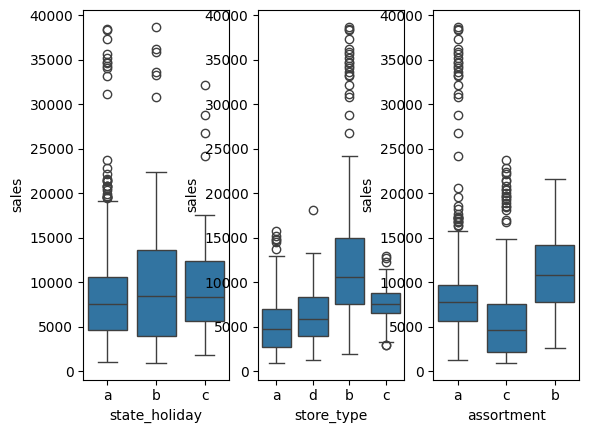

In [68]:
aux1 = df1[(df1['state_holiday'] != '0' ) & (df1['sales'] > 0 )]

plt.subplot(1, 3, 1)
sns.boxplot( x='state_holiday', y='sales', data= aux1 )

plt.subplot(1, 3, 2)
sns.boxplot( x='store_type', y='sales', data= aux1 )

plt.subplot(1, 3, 3)
sns.boxplot( x='assortment', y='sales', data= aux1 )

## 2.0 FEATURE ENGINEERING

In [69]:
df2 = df1.copy()


##### 2.0.1 MAPA MENTAL DE HIPOTESES

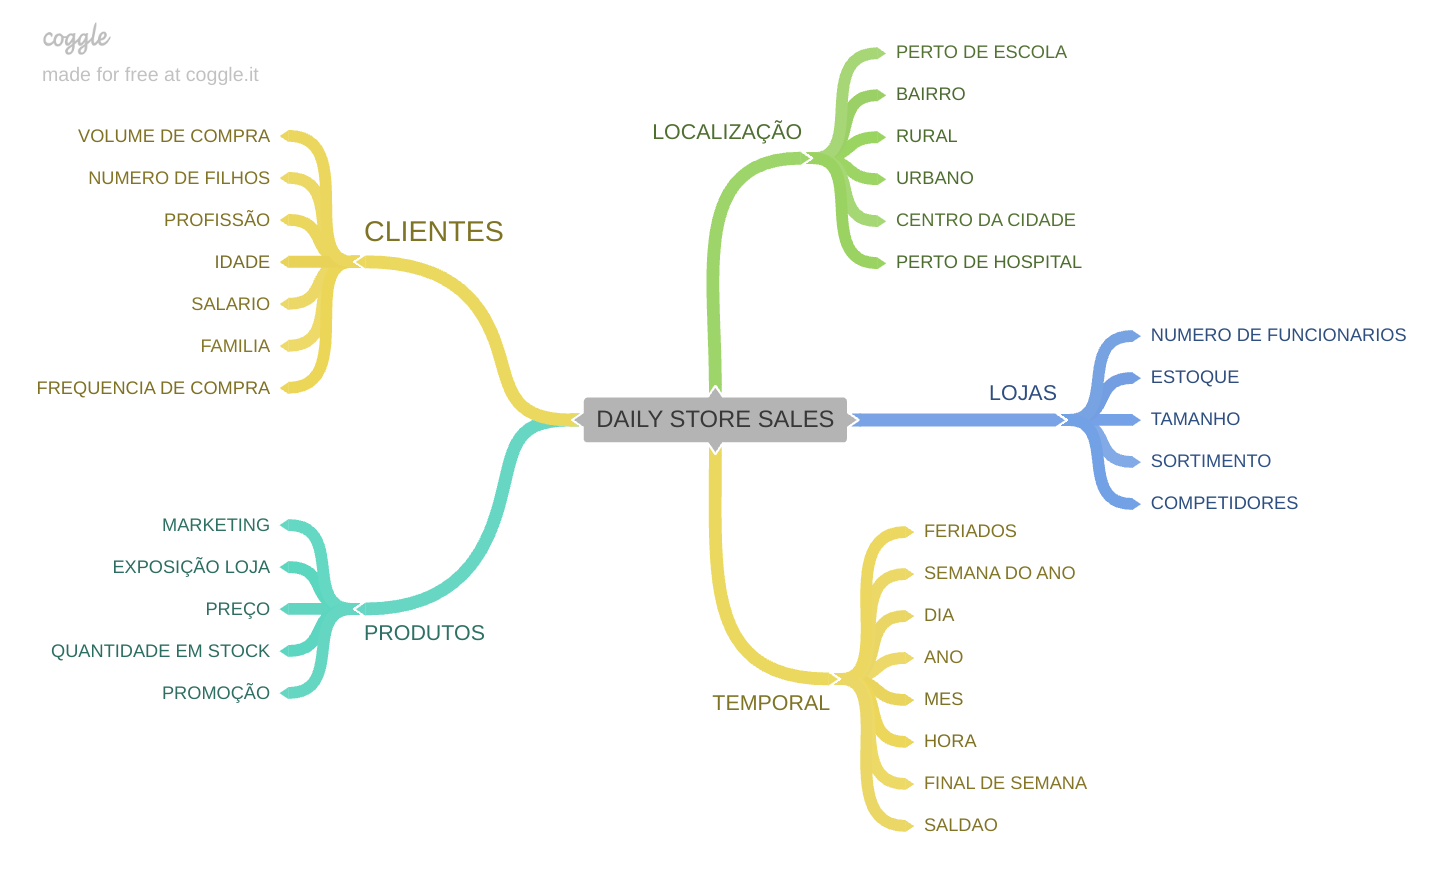

In [70]:
Image('/home/lucas/repos/ds_em_producao/IMG1/MINDMAPHIPOTHESIS.png')

## 2.1 CRIAÇÃO DE HIPOTESES

##### 2.1.1 HIPOTESES LOJA 

**a-** Lojas com maior quadro de funcionarios deveria vender mais.

**b-** Lojas com maior estoque deveria vender mais.

**c-** Lojas com maior porte deveria vender mais.

**d--** Lojas com mais sortimento deveria vender mais.

**e-** Lojas com competidores mais proximos deveriam vender menos.

**f-** Lojas com competidores a mais tempo deveriam vender mais.

##### 2.1.2 HIPOTESES PRODUTO

**a-** Lojas que investem mais em markenting deveria vender mais.

**b-** Lojas com maior exposição de produto deveria vender mais.

**c-** Lojas que tem o menor preço deveria vender mais.

**d-** Lojas com promoções mais agressivas (descontos maiores) deveria vender mais.

**e-** Lojas com promoções ativas por mais tempo deveriam vender mais.

**f-** Lojas com mais dias de promoção deveriam vender mais.

**g-** Lojas com mais promoções consecutivas deveriam vender mais.

##### 2.1.3 HIPOTESES TEMPO 

**a-** Lojas aabertas durante o feriado de natal deveria vender mais.

**b-** Lojas deveriam vender mais ao longo dos anos.

**c-** Lojas deveriam vender mais no segundo semestre do ano.

**d-** Lojas deveriam vender mais depois do dia 10 de cada mês.

**e-** Lojas deveriam vender menos ao final de semana.

**f-** Lojas deveriam vender menos durante os feriados escolares.

## 2.2 LISTA FINAL DE HIPOTESES 

**1--** Lojas com maior sortimento deveria vender mais.

**2-** Lojas com competidores mais proximos deveriam vender menos.

**3-** Lojas com competidores a mais tempo deveriam vender mais.

**4-** Lojas com promoções ativas por mais tempo deveriam vender mais.

**5-** Lojas com mais dias de promoção deveriam vender mais.

**6-** Lojas com mais promoções consecutivas deveriam vender mais.

**7-** Lojas aabertas durante o feriado de natal deveria vender mais.

**8-** Lojas deveriam vender mais ao longo dos anos.

**9-** Lojas deveriam vender mais no segundo semestre do ano.

**10-** Lojas deveriam vender mais depois do dia 10 de cada mês.

**11** Lojas deveriam vender menos ao final de semana.

**12-** Lojas deveriam vender menos durante os feriados escolares.


## 2.3 FEATURE ENGINEERING

In [71]:
df2.sample()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo
401566,755,2,2014-07-08,9001,836,1,0,0,0,d,c,13130.0,12,2003,0,28,2014,0,jul,0


In [72]:
# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.isocalendar().week

# year week 
df2['year_week'] = df2['date'].dt.strftime ( '%Y-%W')

# competition since
df2['competition_since'] = df2.apply(lambda x: datetime.datetime (year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1),axis=1)
df2['competition_time_month'] = ( (df2['date'] - df2['competition_since']) / 30 ).apply(lambda x: x.days ).astype (int)

# promo since
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
df2['promo_since'] = df2['promo_since'].apply ( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w') - datetime.timedelta (days = 7) )
df2['promo_time_week'] = ( (df2['date'] - df2['promo_since']) / 7 ).apply(lambda x: x.days ).astype (int)

# assortment
df2['assortment'] = df2['assortment'].apply( lambda x:'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

# state holiday
df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' if x == 'a' else 'Easter_holiday' if x == 'b' else 'Christmas' if x == 'c' else 'regular_day')

In [73]:
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


## 3.0 FILTRAGEM DE VARIÁVEIS

In [74]:
df3 = df2.copy()

In [75]:
df3.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,...,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,555,1,1,regular_day,1,c,...,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,625,1,1,regular_day,1,a,...,0,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,821,1,1,regular_day,1,a,...,0,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1498,1,1,regular_day,1,c,...,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,559,1,1,regular_day,1,a,...,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


##### 3.1 FILTRAGEM DAS LINHAS 

In [76]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

##### 3.2 SELEÇÃO DAS COLUNAS 

In [77]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop(cols_drop, axis = 1)

## 4.0 ANÁLISE EXPLORATÓRIA DOS DADOS

In [78]:
df4 = df3.copy()

## 4.1 ANÁLISE UNIVARIADA

##### 4.1.1 RESPONSE VARIABLE

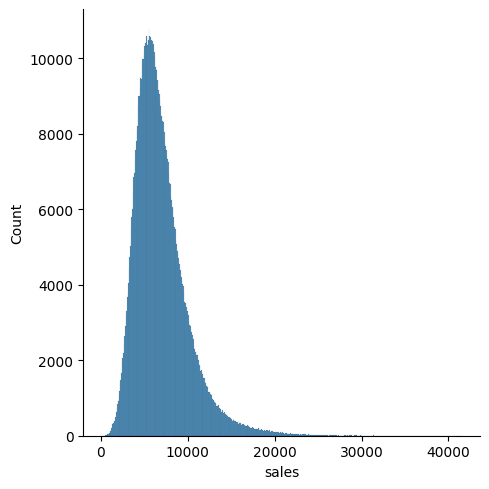

In [79]:
sns.displot( df4['sales'])

##### 4.1.2 NUMERICAL VARIABLE

array([[<Axes: title={'center': 'store'}>,
        <Axes: title={'center': 'day_of_week'}>,
        <Axes: title={'center': 'sales'}>,
        <Axes: title={'center': 'customers'}>],
       [<Axes: title={'center': 'open'}>,
        <Axes: title={'center': 'promo'}>,
        <Axes: title={'center': 'school_holiday'}>,
        <Axes: title={'center': 'competition_distance'}>],
       [<Axes: title={'center': 'competition_open_since_month'}>,
        <Axes: title={'center': 'competition_open_since_year'}>,
        <Axes: title={'center': 'promo2'}>,
        <Axes: title={'center': 'promo2_since_week'}>],
       [<Axes: title={'center': 'promo2_since_year'}>,
        <Axes: title={'center': 'is_promo'}>, <Axes: >, <Axes: >]],
      dtype=object)

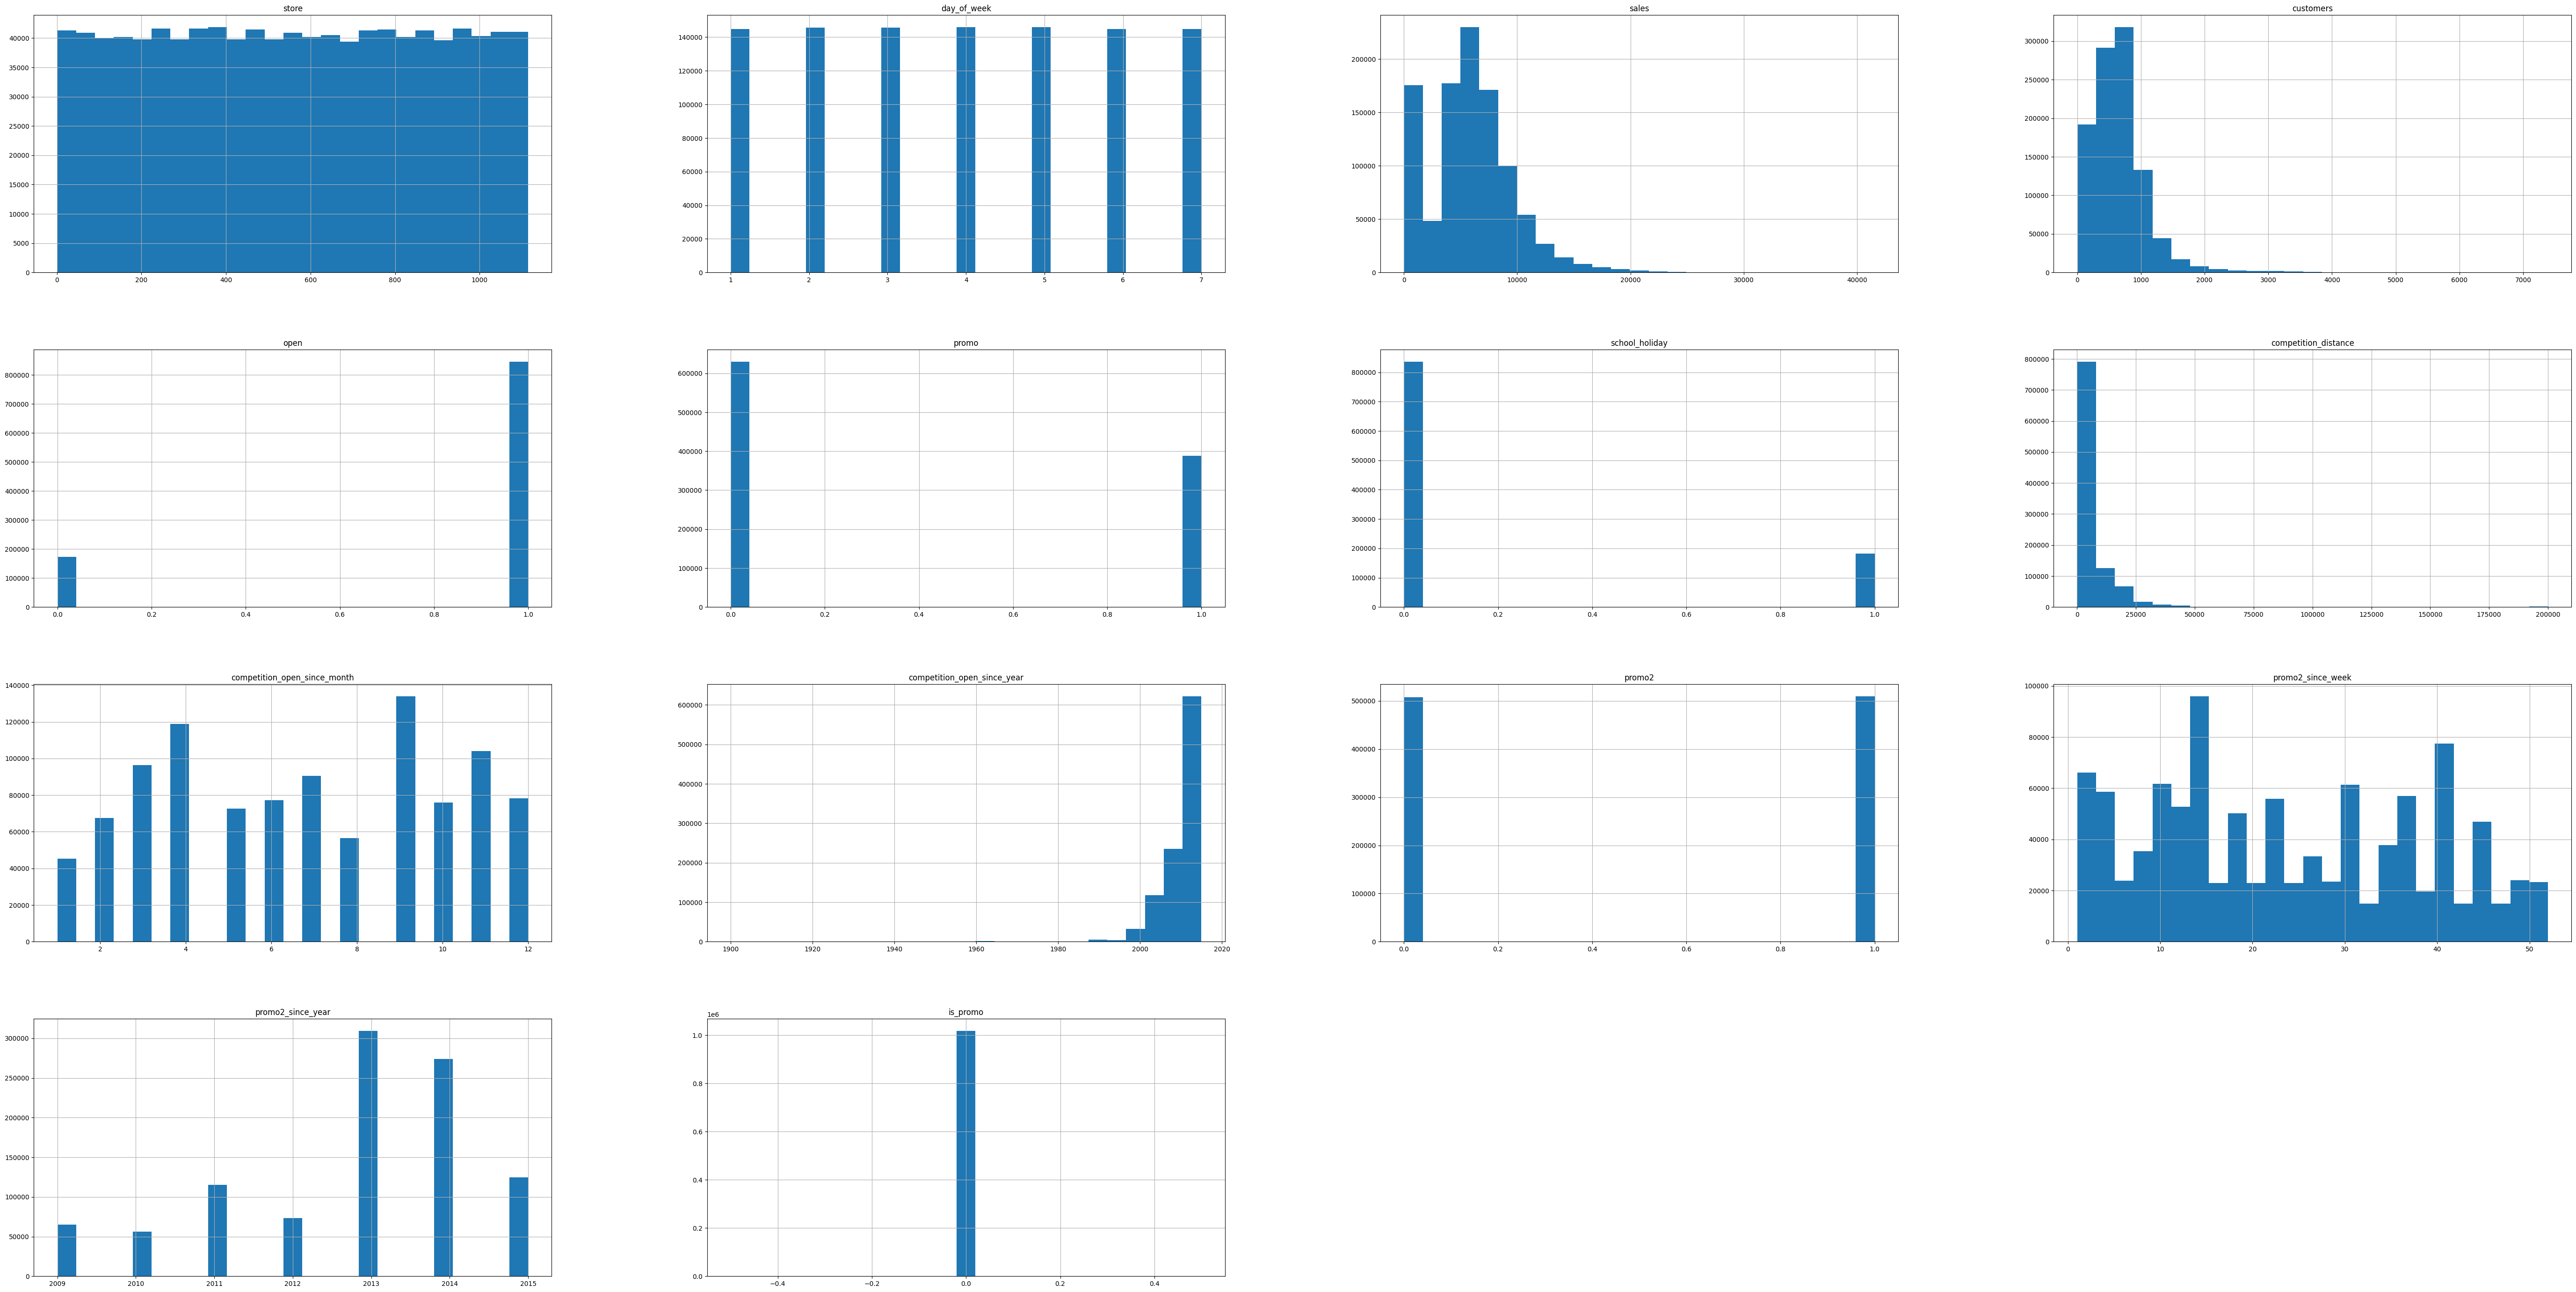

In [80]:
num_attributes.hist( bins=25, figsize=(70, 35))


##### 4.1.3 CATEGORICAL VARIABLE

In [81]:
df4['store_type'].drop_duplicates()

0     c
1     a
12    d
84    b
Name: store_type, dtype: object

/tmp/ipykernel_6649/139607276.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot( a ['state_holiday'], palette=colors)
/tmp/ipykernel_6649/139607276.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot( df4['store_type'], palette=colors)
/tmp/ipykernel_6649/139607276.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot( df4['assortment'], palette=colors)


<Axes: xlabel='sales', ylabel='Density'>

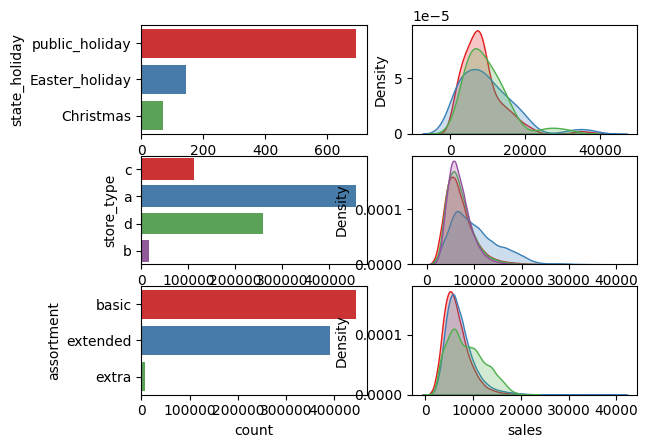

In [82]:
#state_holiday
colors = sns.color_palette("Set1", 3)
plt.subplot( 3, 2, 1)
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot( a ['state_holiday'], palette=colors)

plt.subplot(3 ,2 , 2)
sns.kdeplot(df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', fill=True, color=colors[0])
sns.kdeplot(df4[df4['state_holiday'] == 'Easter_holiday']['sales'], label='Easter_holiday', fill=True, color=colors[1])
sns.kdeplot(df4[df4['state_holiday'] == 'Christmas']['sales'], label='Christmas', fill=True, color=colors[2])

#store_type
colors = sns.color_palette("Set1", 4)
plt.subplot( 3, 2, 3)
sns.countplot( df4['store_type'], palette=colors)

plt.subplot(3 ,2 , 4)
sns.kdeplot(df4[df4['store_type'] == 'a']['sales'], label='a', fill=True, color=colors[0])
sns.kdeplot(df4[df4['store_type'] == 'b']['sales'], label='b', fill=True, color=colors[1])
sns.kdeplot(df4[df4['store_type'] == 'c']['sales'], label='c', fill=True, color=colors[2])
sns.kdeplot(df4[df4['store_type'] == 'd']['sales'], label='d', fill=True, color=colors[3])


#assortment
colors = sns.color_palette("Set1", 3)
plt.subplot( 3, 2, 5)
sns.countplot( df4['assortment'], palette=colors)

plt.subplot(3 ,2 , 6)
sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'], label='basic', fill=True, color=colors[0])
sns.kdeplot(df4[df4['assortment'] == 'extended']['sales'], label='extended', fill=True, color=colors[1])
sns.kdeplot(df4[df4['assortment'] == 'extra']['sales'], label='extra', fill=True, color=colors[2])

## 4.2 ANÁLISE BIVARIADA

##### **H1--** Lojas com maior sortimento deveria vender mais.
**FALSA - Lojas com maior sortimento vendem menos.**

<Axes: xlabel='year_week'>

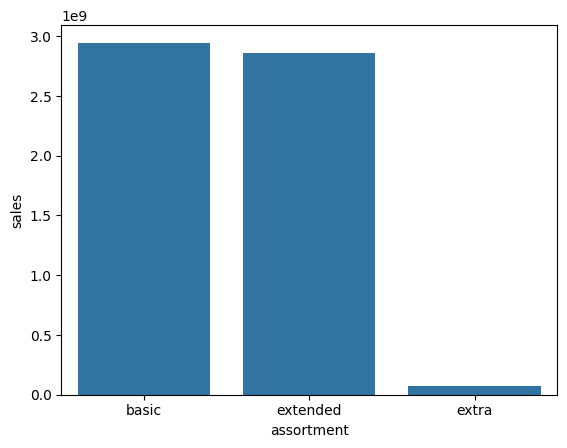

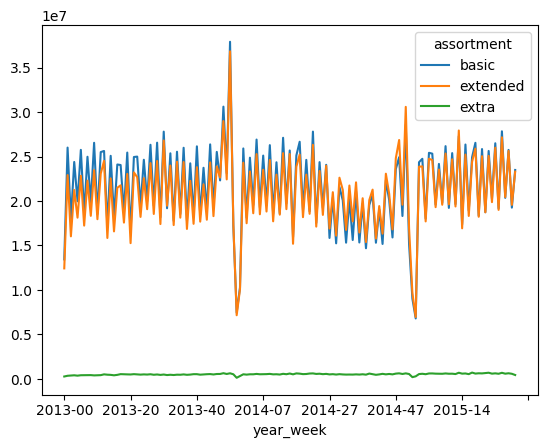

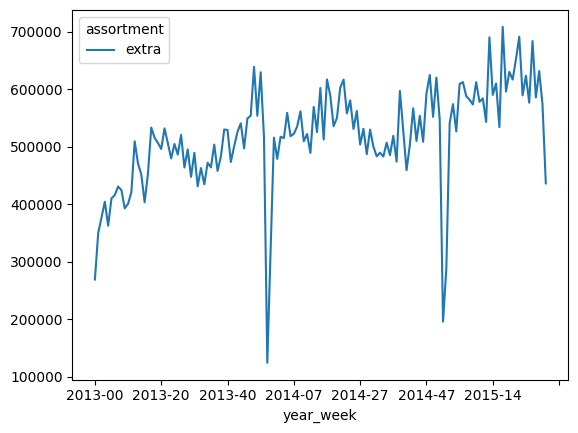

In [83]:
aux1 = df4[['assortment', 'sales']].groupby('assortment').sum().reset_index()
sns.barplot(x = 'assortment', y = 'sales', data = aux1);

aux2 = df4[['assortment', 'sales', 'year_week']].groupby(['year_week', 'assortment']).sum().reset_index()
aux2.pivot( index = 'year_week', columns = 'assortment', values = 'sales').plot()

aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot( index = 'year_week', columns = 'assortment', values = 'sales').plot()

##### **H2-** Lojas com competidores mais proximos deveriam vender menos.
**FALSA Lojas com competidores mais próximos vendem mais.**

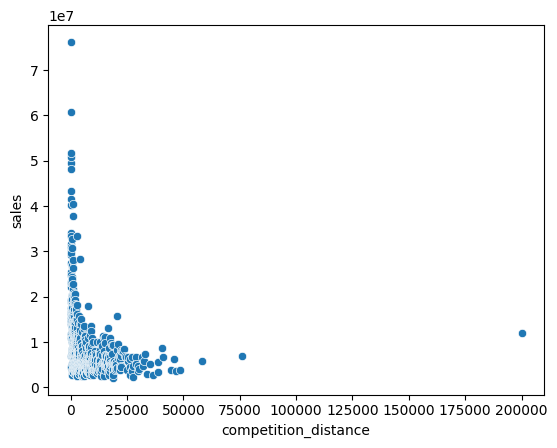

In [84]:
aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()
sns.scatterplot( x = 'competition_distance', y = 'sales', data = aux1);

<Axes: xlabel='competition_distance_binned', ylabel='sales'>

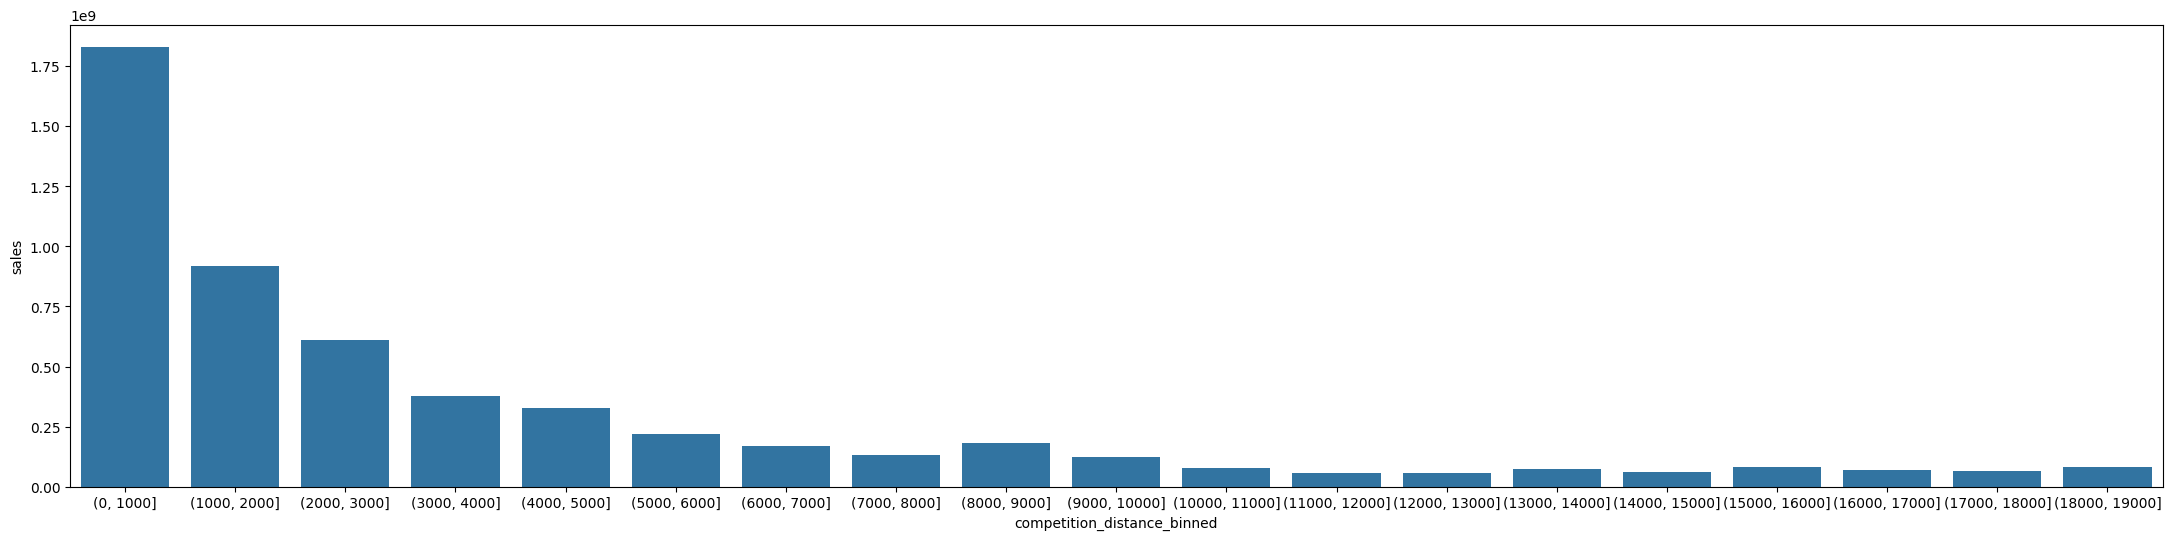

In [85]:
bins = list(np.arange (0, 20000, 1000))
aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins = bins )
aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').sum().reset_index()
plt.figure(figsize=(27, 6))
sns.barplot(x = 'competition_distance_binned', y = 'sales', data = aux2, )

<Axes: >

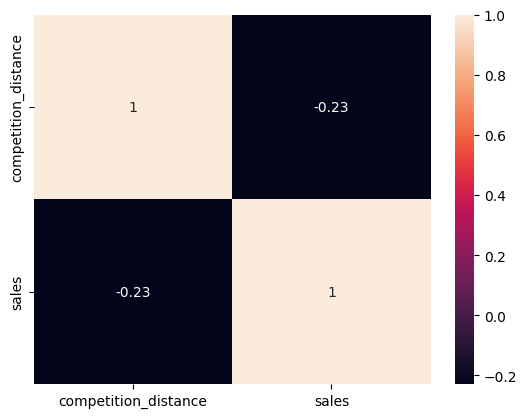

In [86]:
numeric_data = aux1.select_dtypes(include=['number'])
sns.heatmap(numeric_data.corr(method='pearson'), annot=True)

##### **H3-** Lojas com competidores a mais tempo deveriam vender mais.
**FALSA Lojas com competidores a mais tempo vendem menos.**

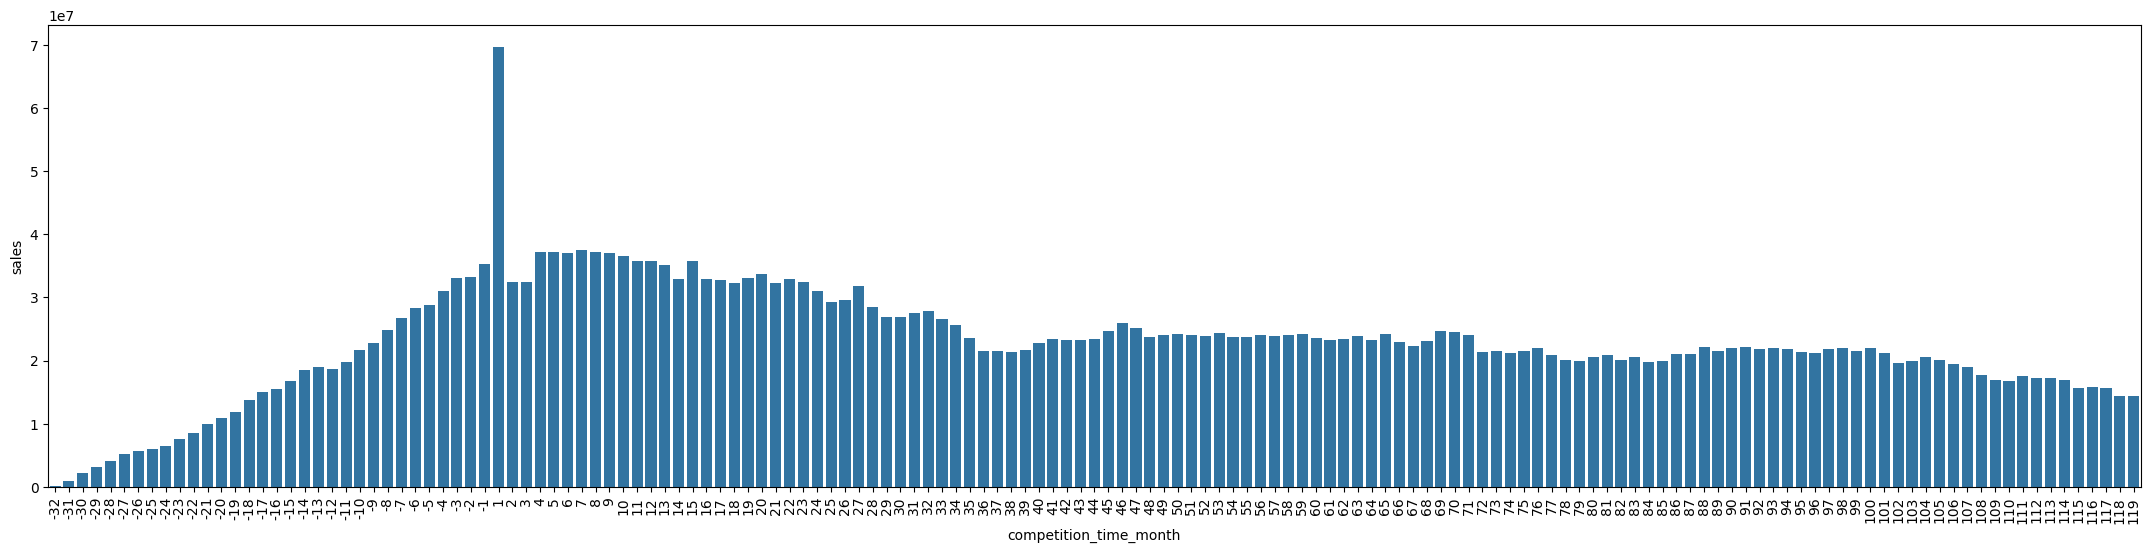

In [87]:
aux1 = df4[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()
aux2 = aux1[(aux1['competition_time_month'] < 120) & (aux1['competition_time_month'] != 0)]
plt.figure(figsize=(27, 6))
sns.barplot(x = 'competition_time_month', y = 'sales', data = aux2)
plt.xticks( rotation = 90 );

<Axes: xlabel='competition_time_month', ylabel='sales'>

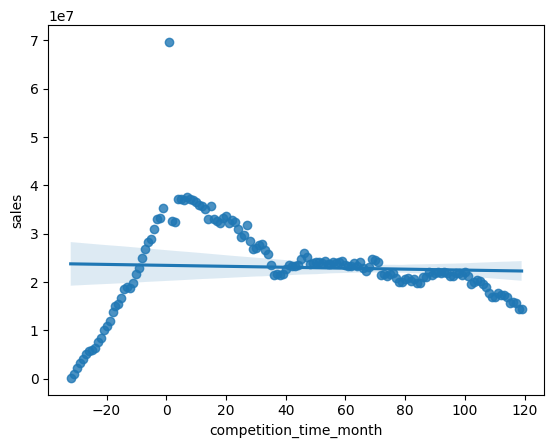

In [88]:
sns.regplot(x = 'competition_time_month', y = 'sales', data = aux2)

<Axes: >

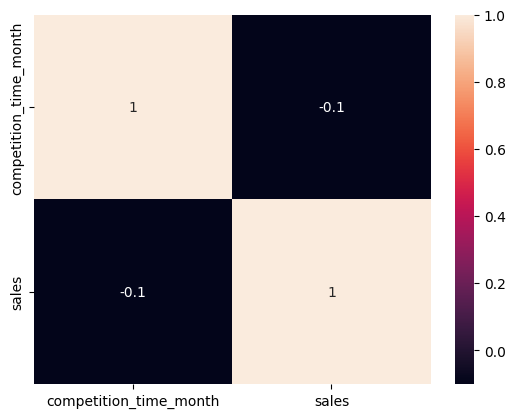

In [89]:
sns.heatmap( aux1.corr (method = 'pearson'), annot = True)

##### **H4-** Lojas com promoções ativas por mais tempo deveriam vender mais.
**FALSA Lojas com promoções ativas por mais tempo vendem menos, depois de um certo período de promoção.**

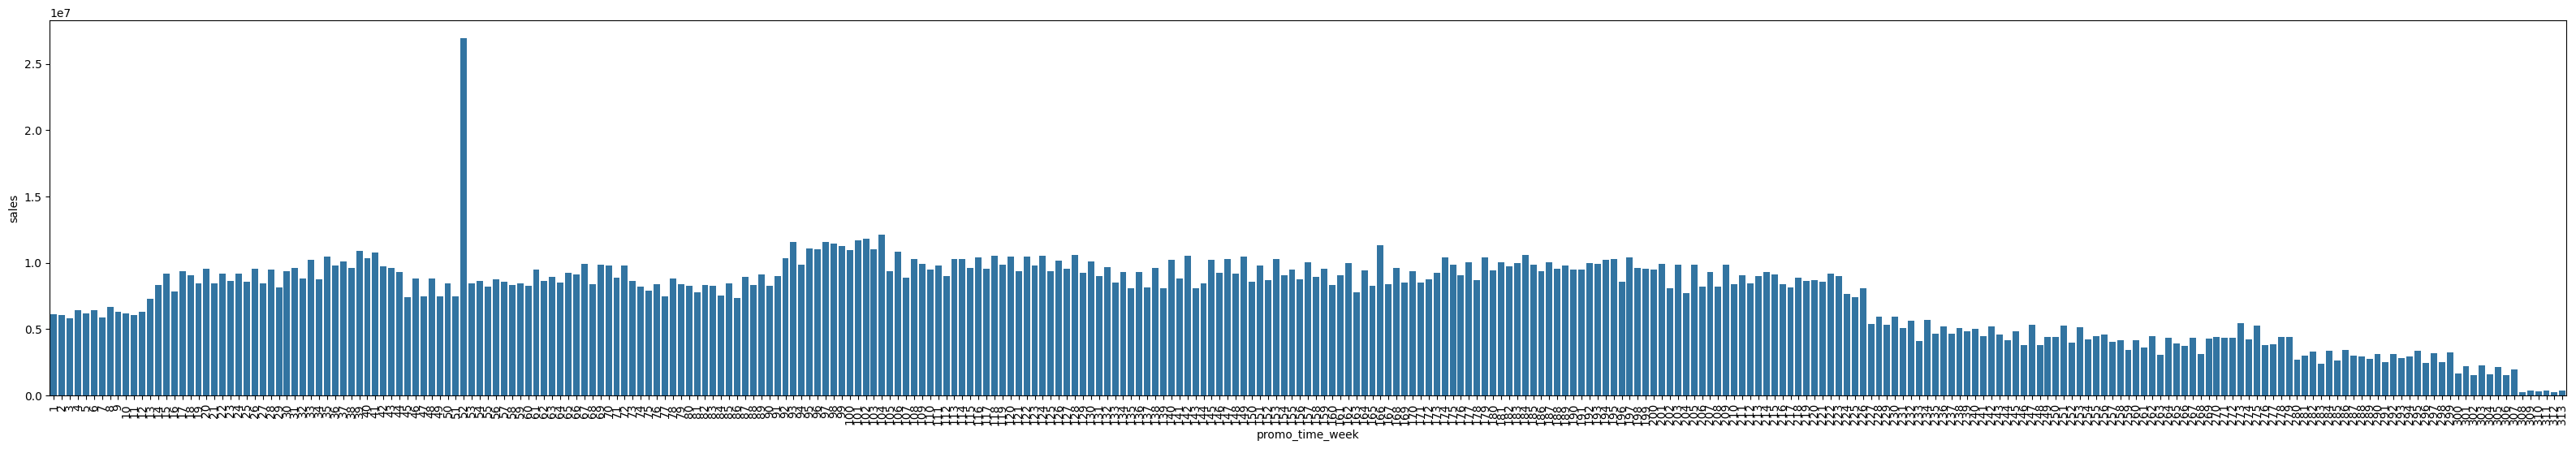

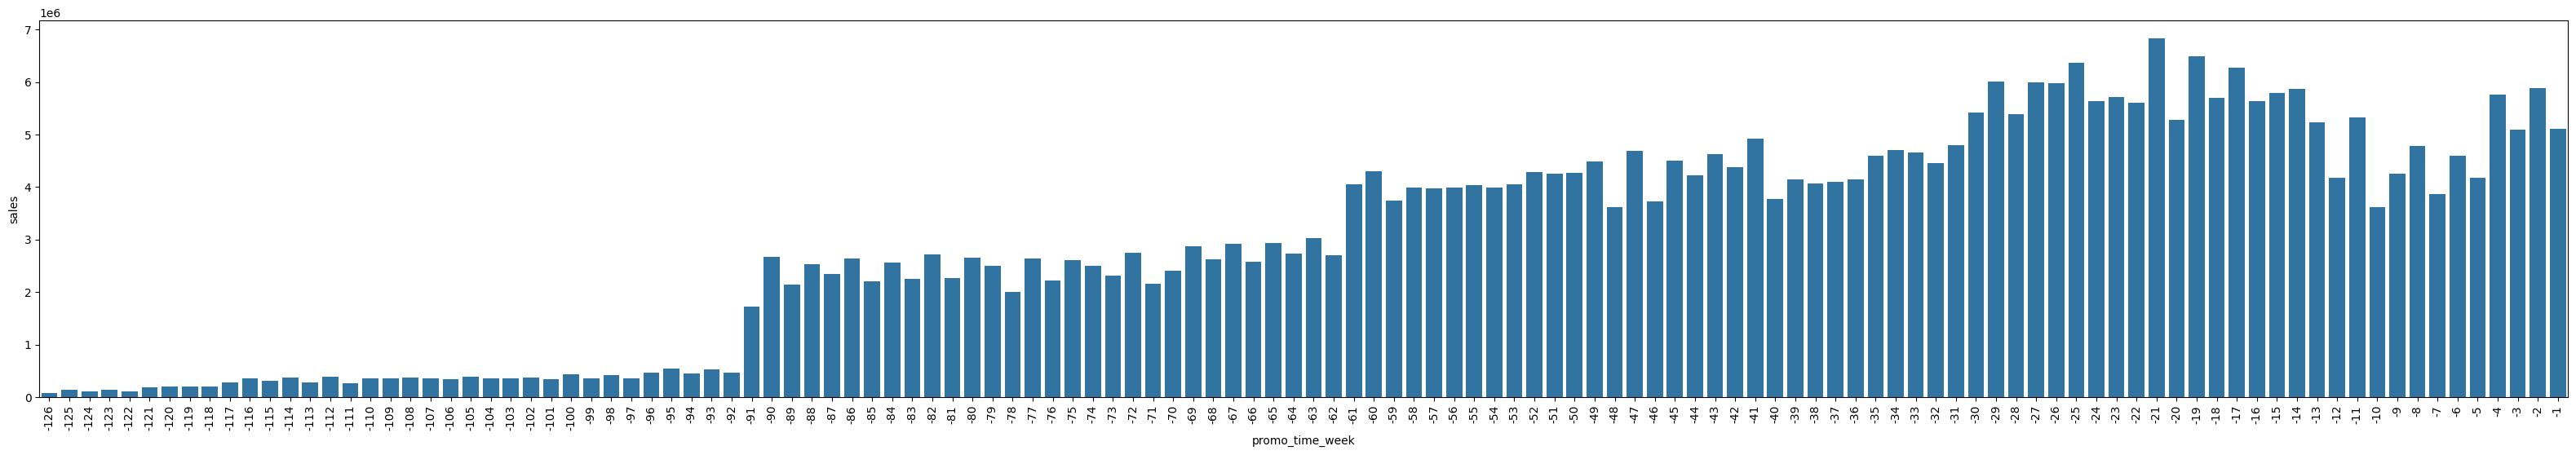

In [90]:
aux1 = df4[['promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index()

aux2 = aux1[aux1['promo_time_week'] > 0]
plt.figure(figsize=(40, 6))
sns.barplot( x ='promo_time_week', y ='sales', data =aux2);
plt.xticks(rotation = 90);

aux3 = aux1[aux1['promo_time_week'] < 0]
plt.figure(figsize=(40, 6))
sns.barplot( x ='promo_time_week', y ='sales', data =aux3);
plt.xticks(rotation = 90);

<Axes: >

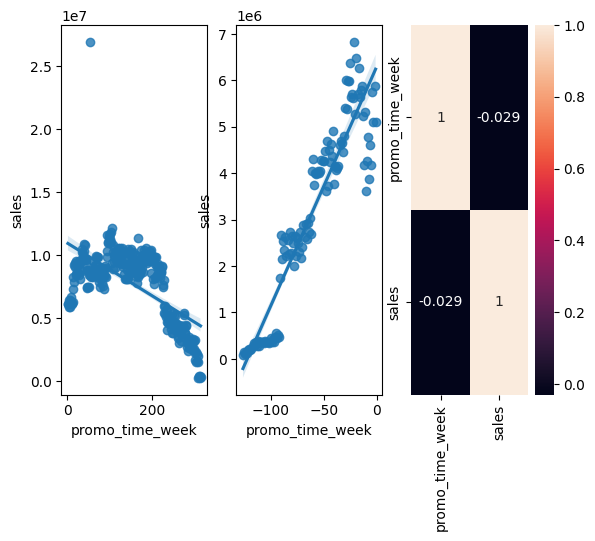

In [91]:
plt.subplot(1, 3, 1)
sns.regplot( x ='promo_time_week', y ='sales', data =aux2);

plt.subplot(1, 3, 2)
sns.regplot( x ='promo_time_week', y ='sales', data =aux3);

plt.subplot(1, 3, 3)
sns.heatmap( aux1.corr (method='pearson'), annot=True)


##### **H5-** Lojas com mais dias de promoção deveriam vender mais.

##### **H6-** Lojas com mais promoções consecutivas deveriam vender mais.
**FALSA Lojas com mais promoções consectuvas vendem menos.**

In [92]:
df4[['promo', 'promo2', 'sales']].groupby(['promo', 'promo2']).sum().reset_index()

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


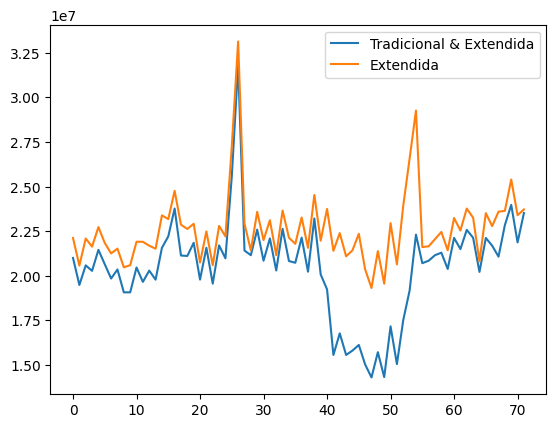

In [93]:
aux1 = df4[(df4['promo'] == 1) & (df4['promo2'] == 1)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
ax = aux1.plot()

aux2 = df4[(df4['promo'] == 1) & (df4['promo2'] == 0)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
aux2.plot(ax = ax)

ax.legend(labels = ['Tradicional & Extendida', 'Extendida']);


##### **H7-** Lojas abertas durante o feriado de natal deveria vender mais.
**FALSA Lojas abertas durante o feriado de natal vendem menos.**

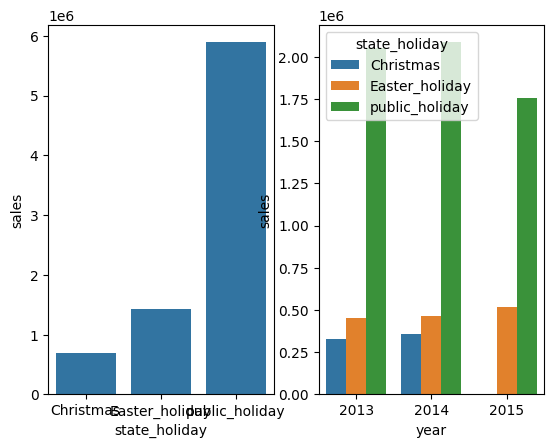

In [94]:
plt.subplot(1, 2, 1)
aux = df4[df4['state_holiday'] != 'regular_day']
aux1 = aux[['state_holiday', 'sales']].groupby('state_holiday').sum().reset_index()
sns.barplot(x = 'state_holiday', y = 'sales', data = aux1);

plt.subplot(1, 2, 2)
aux2 = aux[['year', 'state_holiday', 'sales']].groupby(['year', 'state_holiday']).sum().reset_index()
sns.barplot( x = 'year', y = 'sales', hue = 'state_holiday', data = aux2);



##### **H8-** Lojas deveriam vender mais ao longo dos anos.
**FALSA lojas vendem menos ao longo dos anos**

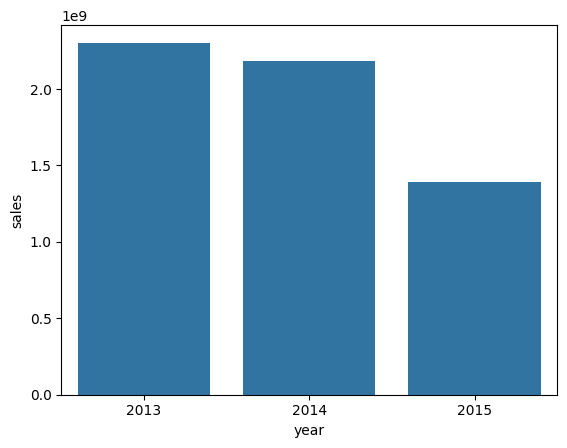

In [95]:
aux1 = df4[['year', 'sales']].groupby('year').sum().reset_index()
sns.barplot(x = 'year', y = 'sales', data = aux1);



<Axes: >

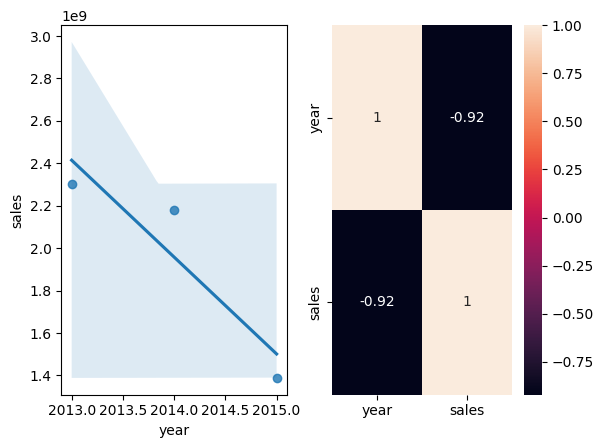

In [96]:
plt.subplot(1, 2, 1)
sns.regplot(x = 'year', y = 'sales', data = aux1);

plt.subplot(1, 2, 2)
sns.heatmap( aux1.corr (method = 'pearson'), annot = True)

##### **H9-** Lojas deveriam vender mais no segundo semestre do ano.
**FALSA lojas vendem menos no segundo semestre do ano.**

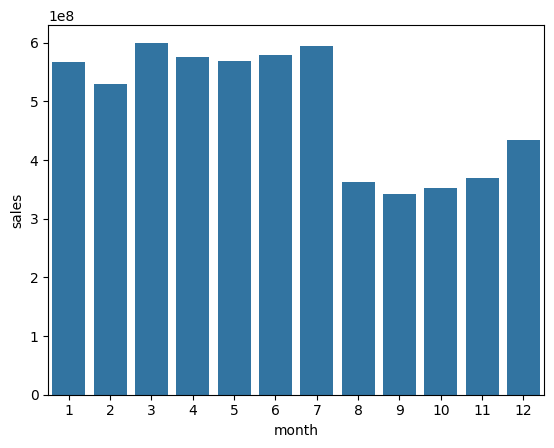

In [97]:
aux1 = df4[['month', 'sales']].groupby('month').sum().reset_index()
sns.barplot(x = 'month', y = 'sales', data = aux1);

<Axes: >

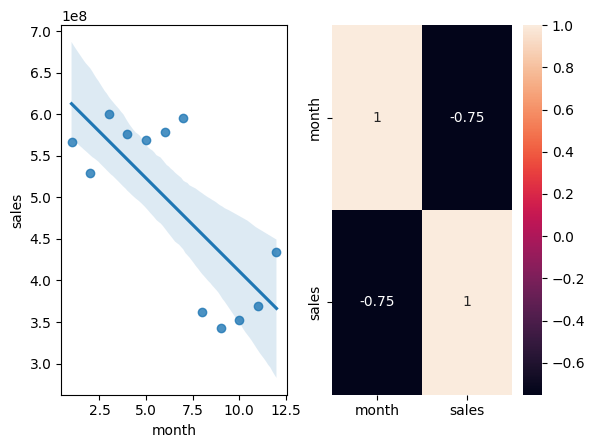

In [98]:
plt.subplot(1, 2, 1)
sns.regplot(x = 'month', y = 'sales', data = aux1);

plt.subplot(1, 2, 2)
sns.heatmap( aux1.corr (method = 'pearson'), annot = True)

##### **H10-** Lojas deveriam vender mais depois do dia 10 de cada mês.
**VERDADEIRA Lojas vendem mais depois do dia 10.**

In [99]:
aux1['before_after'] = aux1['day'].apply( lambda x: 'before_10_days' if x <= 10 else 'after_10_days')
aux2 = aux1[['before_after', 'sales']].groupby('before_after').sum().reset_index()
sns.barplot( x = 'before_after', y = 'sales', data = aux2)

KeyError: 'day'

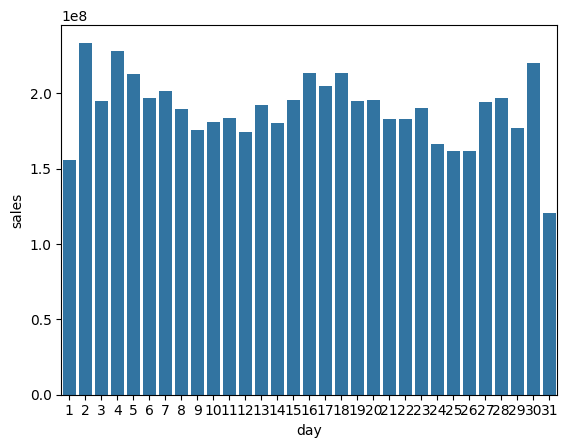

In [ ]:
aux1 = df4[['day', 'sales']].groupby('day').sum().reset_index()
sns.barplot(x = 'day', y = 'sales', data = aux1);

<Axes: >

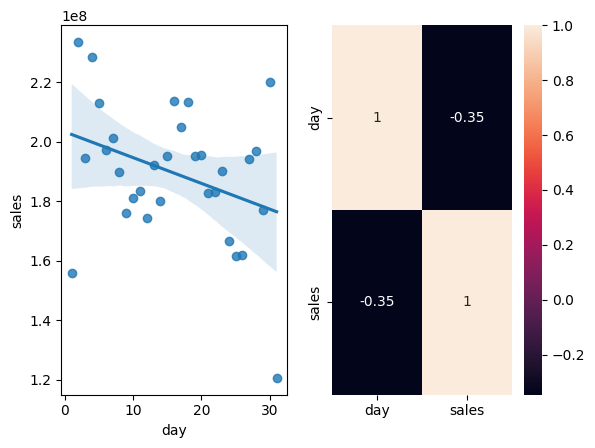

In [ ]:
plt.subplot(1, 2, 1)
sns.regplot(x = 'day', y = 'sales', data = aux1);

plt.subplot(1, 2, 2)
sns.heatmap( aux1.corr (method = 'pearson'), annot = True)

##### **H11** Lojas deveriam vender menos ao final de semana.
**VERDADEIRA Lojas vendem menos nos finais de semana**

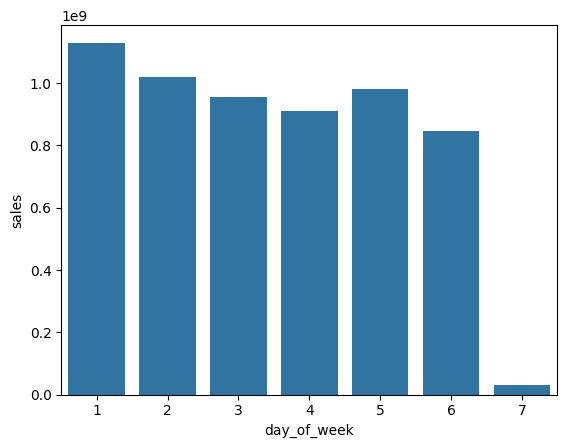

In [ ]:
aux1 = df4[['day_of_week', 'sales']].groupby('day_of_week').sum().reset_index()
sns.barplot(x = 'day_of_week', y = 'sales', data = aux1);

<Axes: >

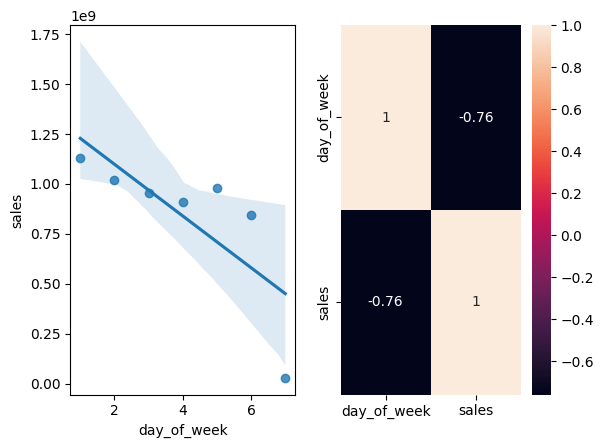

In [ ]:
plt.subplot(1, 2, 1)
sns.regplot(x = 'day_of_week', y = 'sales', data = aux1);

plt.subplot(1, 2, 2)
sns.heatmap( aux1.corr (method = 'pearson'), annot = True)

##### **H12-** Lojas deveriam vender menos durante os feriados escolares.
**VERDADEIRA Lojas vendem menos aos feriados escolares, exceto o mês de Agosto**

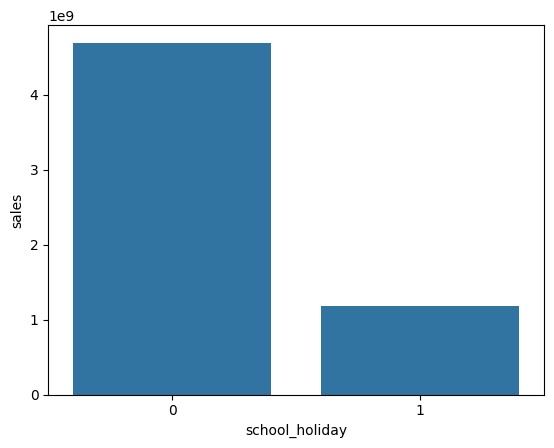

In [ ]:
aux1 = df4[['school_holiday', 'sales']].groupby('school_holiday').sum().reset_index()
sns.barplot( x = 'school_holiday', y = 'sales', data = aux1);

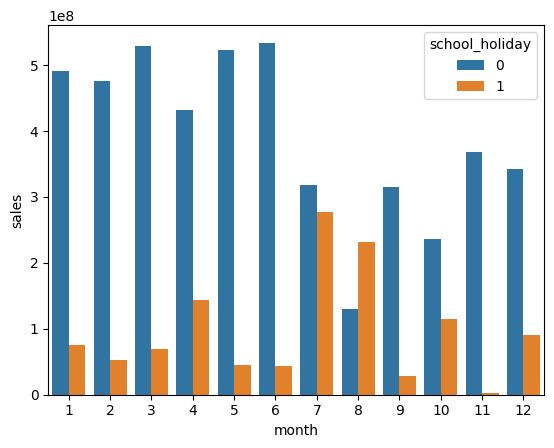

In [ ]:
aux2 = df4[['month', 'school_holiday', 'sales']].groupby(['month', 'school_holiday']).sum().reset_index()
sns.barplot( x = 'month', y = 'sales', hue = 'school_holiday', data = aux2);

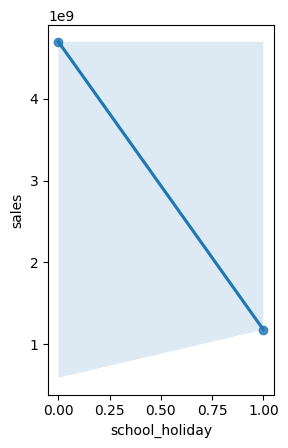

In [ ]:
plt.subplot(1, 2, 1)
sns.regplot(x = 'school_holiday', y = 'sales', data = aux1);

##### 4.2.1 RESUMO DAS HIPOTESES

In [ ]:
tab = [ ['HIPOTESES', 'CONCLUSÃO', 'RELEVANCIA'],
        ['H1', 'FALSA', 'BAIXA'],
        ['H2', 'FALSA', 'MÉDIA'],
        ['H3', 'FALSA', 'MÉDIA'],
        ['H4', 'FALSA', 'BAIXA'],
        ['H5', '-----', '-----'],
        ['H6', 'FALSA', 'BAIXA'],
        ['H7', 'FALSA', 'MÉDIA'],
        ['H8', 'FALSA', 'ALTA'],
        ['H9', 'FALSA', 'ALTA'],
        ['H10', 'FALSA', 'ALTA'],
        ['H11', 'FALSA', 'ALTA'],
        ['H12', 'FALSA', 'BAIXA'],
        ]
print(tabulate( tab, headers = 'firstrow'))
## 4.3 ANÁLISE MULTIVARIADA

HIPOTESES    CONCLUSÃO    RELEVANCIA
-----------  -----------  ------------
H1           FALSA        BAIXA
H2           FALSA        MÉDIA
H3           FALSA        MÉDIA
H4           FALSA        BAIXA
H5           -----        -----
H6           FALSA        BAIXA
H7           FALSA        MÉDIA
H8           FALSA        ALTA
H9           FALSA        ALTA
H10          FALSA        ALTA
H11          FALSA        ALTA
H12          FALSA        BAIXA


## 4.3 ANÁLISE MULTIVARIADA

##### 4.3.1 NUMERICAL ATTRIBUTES 

<Axes: >

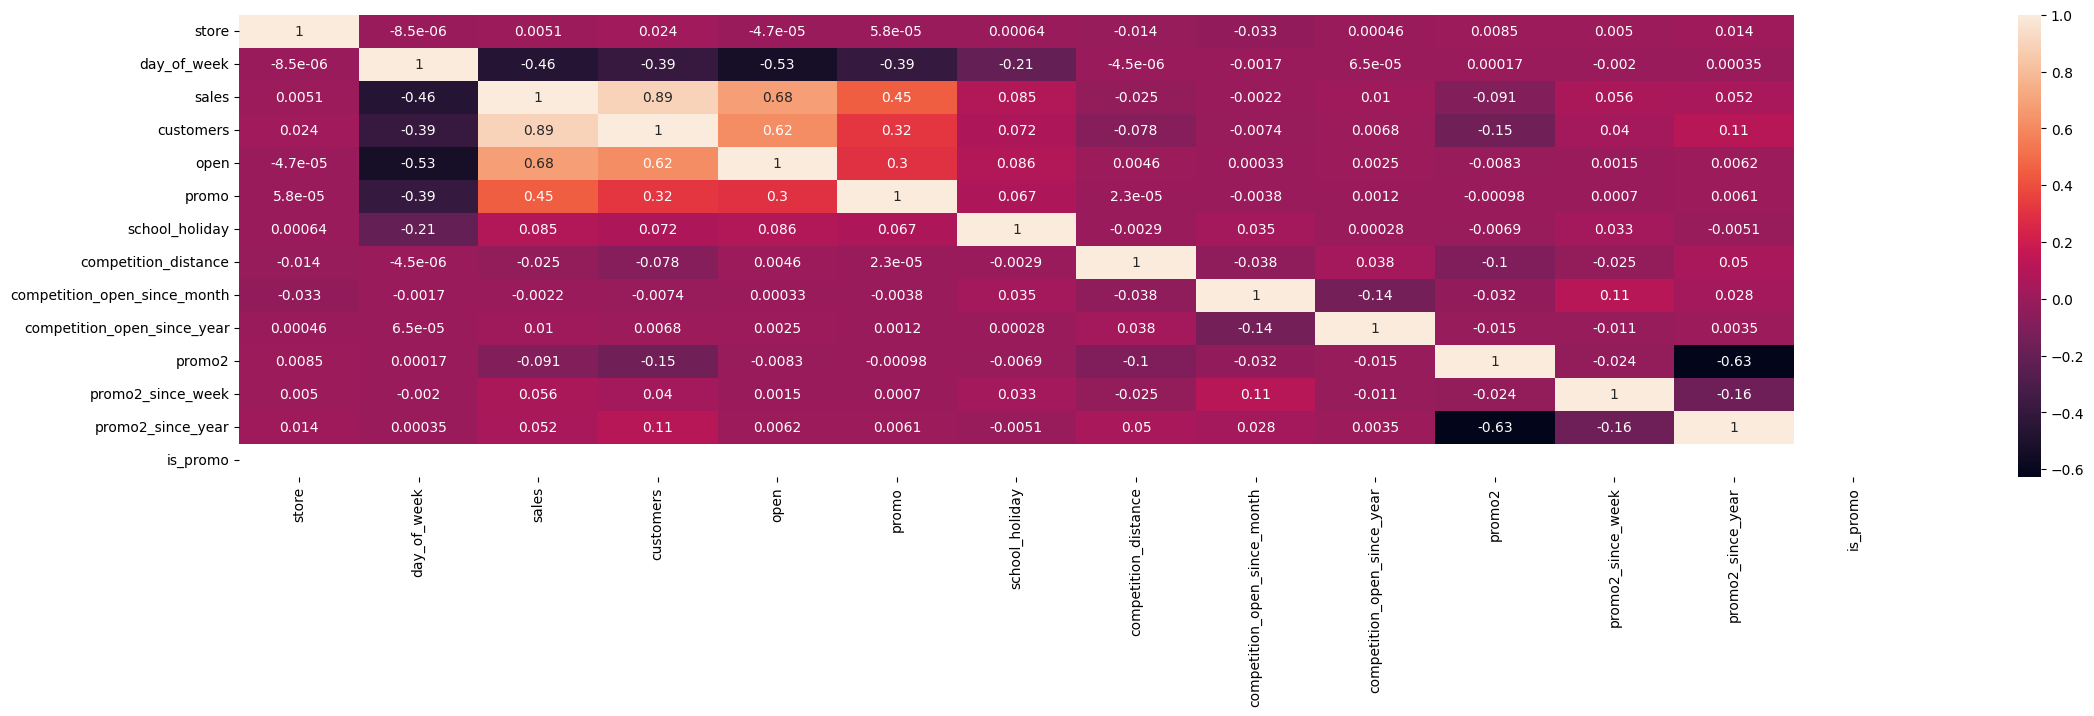

In [ ]:
correlation = num_attributes.corr( method = 'pearson')
plt.figure(figsize=(27, 6))
sns.heatmap( correlation, annot = True)

##### 4.3.2 CATEGORICAL ATTRIBUTES

In [143]:
a = df4.select_dtypes( include = 'object')
a.head()

,state_holiday,store_type,assortment,year_week
0,regular_day,c,basic,2015-30
1,regular_day,a,basic,2015-30
2,regular_day,a,basic,2015-30
3,regular_day,c,extended,2015-30
4,regular_day,a,basic,2015-30


<Axes: >

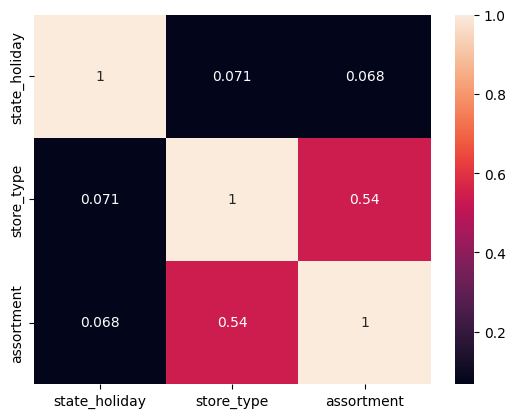

In [174]:
a1 = cramer_v(a['state_holiday'], a['state_holiday'])
a2 = cramer_v(a['state_holiday'], a['store_type'])
a3 = cramer_v(a['state_holiday'], a['assortment'])

a4 = cramer_v(a['store_type'], a['state_holiday'])
a5 = cramer_v(a['store_type'], a['store_type'])
a6 = cramer_v(a['store_type'], a['assortment'])

a7 = cramer_v(a['assortment'], a['state_holiday'])
a8 = cramer_v(a['assortment'], a['store_type'])
a9 = cramer_v(a['assortment'], a['assortment'])

d = pd.DataFrame( {'state_holiday': [a1, a2, a3],
                    'store_type': [a4, a5, a6],
                    'assortment': [a7, a8, a9] 
})

d = d.set_index( d.columns )
sns.heatmap(d, annot = True)

...